# The Logistic problem

The *Logistic* equation is used as a model to describe the evolution of a population over a given time interval. Its form is of the type

$$x_{n+1} = kx_n(1-x_n)$$

where $k$ is a constant and $x_n$ is the population at the *generation* $n$, so that the popolation at the next generation is $x_{n+1}$ (the popolation is *normalized* to 1). 

Such equation can be related to a differential equation such that

$$x_{t+\Delta t} = kx_t(1-x_t) \ \rightarrow \ x_{t+\Delta_t} - x_t = \Delta x = kx_t(1-x_t)-x_t = x_t(k-1) - kx_{t}^{2}$$ 

Such $\Delta x$ corresponds to a specific $\Delta t$ ($\Delta x$ is the variation in the population during a time interval $\Delta t$) that can be set to 1, so that: 

$$\Delta x = [x_t(k-1) - kx_{t}^{2}]\Delta t \ \longrightarrow \ \dfrac{dx}{dt} =x_t(k-1) - kx_{t}^{2}$$

In the last step, we took the limit for $\Delta t \rightarrow 0$.

This equation will be analitically solved by using *sympy*: the symbolic library of Python. 

In a later section, we will employ a numerical method to find solutions for $\Delta t$ *not* reducible to an infinitesimal value.  

In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

sym.init_printing(use_latex=True) 

Set a value of the $k$ constant, and an initial value for $x$ ($x(0)$)

In [2]:
k_val=2.8
x_ini=0.1

Define $k, t$ and $x_0$ as *sympy* symbols that will be associated to *real* and *positive* variables; also, declare $x$ to be a function of $t$:   

In [3]:
k, t, x0 = sym.symbols('k t x0', real=True, positive=True)
x = sym.Function('x')(t)

Define *xp* as the derivative of *x* with respect to *t*, and write down the differential equation *eq* as

$$\dfrac{dx}{dt}+kx^2 - (k-1)x = 0$$

Note that only the left hand side of the equation is needed.

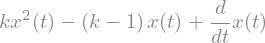

In [4]:
xp=x.diff(t)
eq=xp+k*x**2-(k-1)*x
display(eq)

Define the *logistic* function that will take *k_val* and *x_ini* as parameters, and will return the solution of the differential equation: the *right hand side* of the solution $x(t) =\ $*eq*, subjected to the initial condition (*ics*) $x(0) = x0$. The solution is saved in the symbol *x_tp*:  

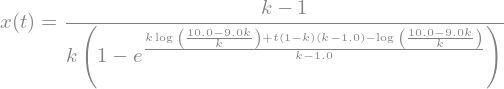

In [5]:
def logistic(x0, kv, prt=False):
    par={k: kv}
    x_t=sym.dsolve(eq, x, ics={x.subs(t, 0): x0})
    if prt:
       display(x_t.simplify())
    x_tp=x_t.rhs.subs(par)
    return x_tp

x_tp=logistic(x_ini, k_val, prt=True)

Such symbolic function is *transformed* in a *numpy* function by using the *lambdify* function of *sympy*. Below, *x_tp* is trasformed in the *numpy* function *x_tl* (a function of *t*): 

In [6]:
def plot_analytic():
   x_tl=sym.lambdify(t, x_tp, 'numpy')
   t_list=np.linspace(0., 10, 100)
   x_list=x_tl(t_list).real

   plt.figure(figsize=(4,3))
   plt.plot(t_list, x_list)
   plt.ylim(0., 1.)
   plt.xlim(0., 6.)
   plt.xlabel("time")
   plt.ylabel("Population")
   plt.show() 

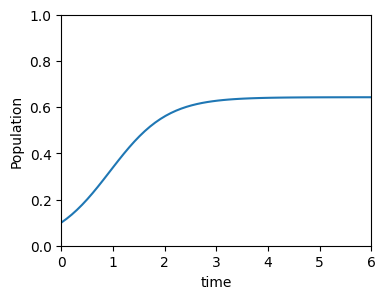

In [7]:
plot_analytic()

Below, we compute the limit value of $x(t)$ for $x\rightarrow\infty$, that is:  $$\lim_{t\rightarrow\infty} x(t)$$

In [8]:
x_limit=x_tp.limit(t, sym.oo).evalf()
print("Limit value for x: %6.4f" % x_limit)

Limit value for x: 0.6429


## Numerical computation

For $\Delta t = 1$

Do study in detail the class below which implements the numerical computation of the logistic problem. Depending on the value of $k$, the numerical solution does agree with the analitycal one (low values of $k$) or significantly diverges, by showing an *oscillating* (or even *fractal*) behaviour.

In [9]:
# Logistic class 
# Version 2.0 - 04/07/2023

# Class methods definition: use of the decorator @classmethod
# to define functions within a class that can be called without
# the need to create any instance of the class itself.

# The Logistic class is defined for such purpose: it groups all
# the functions needed to deal with the logist problem.
# In this case there is no a __init__ constructor, and
# all the relevant variables (that is, 'relevant' for the 
# calculation) are class attribute (instead of instance 
# attributes).
# All the functions of the class are declared as 
# class methods by using the appropriate decorator. Such
# functions have not a self argument, but have a cls one, and directly 
# manipulate the class attributes


import numpy as np
import matplotlib.pyplot as plt

class Logistic:
      x0=0.1
      k=2.5
      niter=5000
      last=100
      digits=5
      x_last=[]
      sx=None
    
      @classmethod  
      def logistic_function(cls):
          '''
          Implementation of the logistic function
          x_(n+1) = k*x_n*(1-x_n)
          
          Note that the 'for' loop returns an 'iterator' (ix) instead
          of the list of x_n values. The actual values will be 
          produced by the instruction 'next' used in the method
          'count'
          '''
          
          x=cls.x0
          
          for _ in range(cls.niter):
              ix=cls.k*x*(1-x)
              x=ix   
              ix=round(ix, cls.digits)
                            
              yield ix             
      
      @classmethod
      def count(cls):
          '''
          Produces the set of 'stable points' in the sequence of x_n values
          by considering only the cls.last values out of the cls.niter ones
          
          The list of the cls.last values is stored in the cls.x_last
          attribute. The real set (list of 'unique' values) is produced
          by the Python 'set' function
          '''
          
          x_list_generator=cls.logistic_function()
          
          # Generate and discard all of the first (cls.niter - cls.last)
          # iterations
          for _ in range(cls.niter-cls.last):
              next(x_list_generator)
                        
          # Consider the cls.last iterations only and store the values
          # in the cls.x_last list
          cls.x_last=[]    
          for _ in range(cls.last):
              xl=next(x_list_generator)
              cls.x_last.append(xl)
          
          # Prepare the set of 'stable points' and put it in the
          # cls.sx attribute
          sx=set(cls.x_last)
          cls.sx=sx
      
      @classmethod
      def get_stable_points_set(cls, k):
          '''
          Sets the value of the k constant and returns the set of 
          'stable points', by calling the count method
          
          Args:
              k: value of the constant k
          '''
          cls.set_k(k)
          cls.count()
          
          return cls.sx    
       
      @classmethod
      def set_k(cls, k):
          '''
          Sets the values of k
          
          Args:
              k: value of the k constant           
          '''
          cls.k=k 
       
      @classmethod
      def get_k(cls):
          '''
          Returns the value of k
          '''
          return cls.k
       
      @classmethod
      def set_param(cls, xini=0.1, niter=5000, last=100, digits=5):
          '''
          Sets the values of parameters used in the calculation
          
          Args:
              xini:   initial value of the population (default 0.1)
              niter:  total number of iterations (default 5000)
              last:   number of iterations in the last part of the
                      sequence to be considered to find the 'stable 
                      points' of the sequence itself (default 100) 
              digits: number of decimal digits used in the definition 
                      of the 'unique' values of the set; that is, two
                      values are considered equivalent if they 
                      differ less than 10^(-digits) (defaut 5)
          '''
          cls.x0=xini
          cls.niter=niter
          cls.last=last
          cls.digits=digits
       
      @classmethod    
      def get_niter(cls):
          '''
          Returns the total number of iterations 
          '''
          
          return cls.niter
       
      @classmethod
      def plot(cls, k=2.5, niter=30, xini=0.1, bins=20, hist=False):
          '''
          Makes a plot of the first niter points of the sequence x_n
          
          Args:
              k:     value of the k constant (default 3.5)
              niter: number of iterations to be considered (default 30)
              xini:  initial value of the population (x0; default 0.1)
              bins:  number of bins for the histogram (relevant if
                     hist eq True) (default 20)
              hist:  if True, an histogram representing the distribution
                     of the x_n values is plotted (default False)
          '''
          
          k_orig=cls.get_k()
          niter_orig=cls.get_niter()
          x0_orig=cls.x0
          
          cls.set_param(niter=niter, xini=xini)
          cls.set_k(k)
          
          x_list_generator=cls.logistic_function()
          x_list=list(x_list_generator)
          
          cls.set_param(niter=niter_orig)
          cls.k=k_orig
          cls.x0=x0_orig
          
          it_list=list(range(niter))
          plt.figure(figsize=(4,3))
          if not hist:
             plt.plot(it_list, x_list)
             plt.xlim(0)
             plt.ylim(0,1)
             plt.xlabel("Generation")
             plt.ylabel("$X_i$")
          else:
             plt.hist(x_list, bins) 
             plt.xlim(0., 1.)
             plt.xlabel("X_i")
             plt.ylabel("Counts")
          plt.show()

For the case $k=2.8$, after some initial oscillations, the population evolves toward a stable condition and, after about 15 *generations*, it reaches a stable population of 0.6429, that agrees with the value analitically computed:  

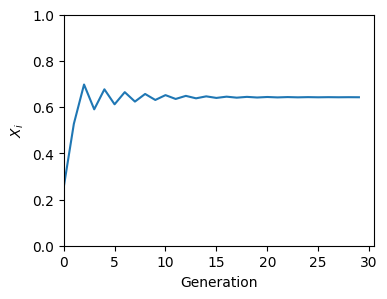

Stable points set:  {0.64286}


In [10]:
Logistic.plot(k=k_val)
print("Stable points set: ", Logistic.get_stable_points_set(k_val))

The same is true for $k=2.9$:

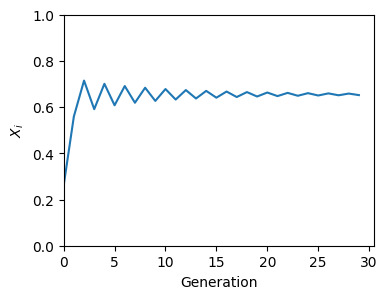

Stable points set:  {0.65517}


In [11]:
Logistic.plot(k=2.9)
print("Stable points set: ", Logistic.get_stable_points_set(2.9))

and, indeed, by following the analytic approach we find:

In [12]:
x_tp=logistic(x_ini, 2.9)
x_limit=x_tp.limit(t, sym.oo).evalf()
print("Limit value for x: %6.4f" % x_limit)

Limit value for x: 0.6552


For lower values of $k$, the equilibrium state is quickly reached and, again, the agreement with analytical case is perfect: 

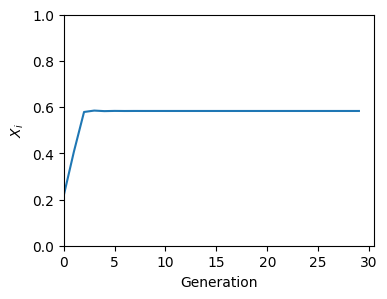

Stable points set:  {0.58333}


In [13]:
Logistic.plot(k=2.4)
print("Stable points set: ", Logistic.get_stable_points_set(2.4))

which is the same result we get from the analytic calculation:

In [14]:
x_tp=logistic(x_ini, 2.4)
x_limit=x_tp.limit(t, sym.oo).evalf()
print("Limit value for x: %6.4f" % x_limit)

Limit value for x: 0.5833


However, for values of $k$ larger than about 3, we observe different behaviours!

Let's consider the case $k=3.1$:

#### Numerical case: 

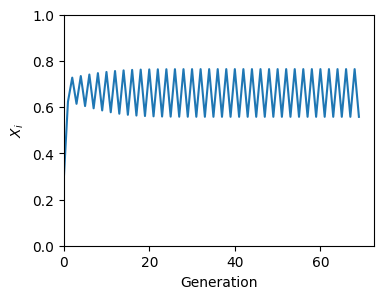

Set of stable points:  {0.76457, 0.55801}


In [15]:
Logistic.plot(k=3.1, niter=70)
p_set=Logistic.get_stable_points_set(k=3.1)
print("Set of stable points: ", p_set)

An oscillating behaviour is obtained: after a few initial generations (starting from the default x0=0.1), the population keeps oscillating between the values 0.765 and 0.558. The behaviour can also be seen in an histogram representation of the $x_n$ values:  

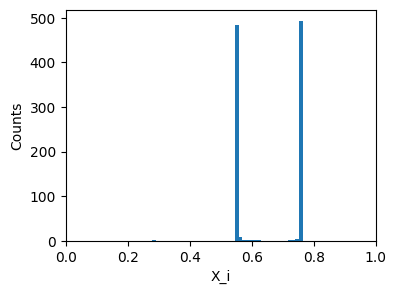

In [16]:
Logistic.plot(k=3.1, niter=1000, bins=40, hist=True)

The histogram above is produced over 1000 generations. It clearly shows a very sharp *bimodal* distribution centered on the two values 0.558 and 0.764. This behaviour is ***not*** reproduced in the analytic model.   

#### Analytic case

The population reaches a stable equilibrium:

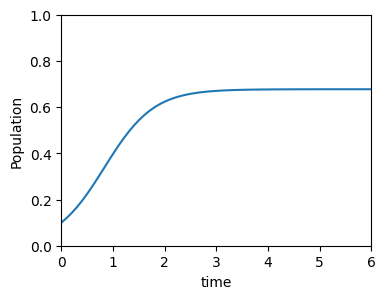

Limit value for x: 0.6774


In [17]:
x_tp=logistic(x_ini, 3.1)
plot_analytic()
x_limit=x_tp.limit(t, sym.oo).evalf()
print("Limit value for x: %6.4f" % x_limit)

Let's study the behaviour of the logistic function as a function of $k$: 

In [18]:
def plot(kmin, kmax, npoints=100):
    
    k_list=np.linspace(kmin, kmax, npoints)
    
    plt.figure(figsize=(5,4))
    
    for ik in k_list:
        isx=Logistic.get_stable_points_set(ik)
        isx_size=len(isx)
        ik_list=np.repeat(ik, isx_size)
        is_list=list(isx)
        plt.plot(ik_list, is_list, "k.", markersize=2)
    
    plt.xlim(kmin, kmax)
    plt.xlabel("K")
    plt.ylabel("X")
    plt.show()

As $k$ changes from 2.9 to 3.5, two *bifurcation* points can be observed:

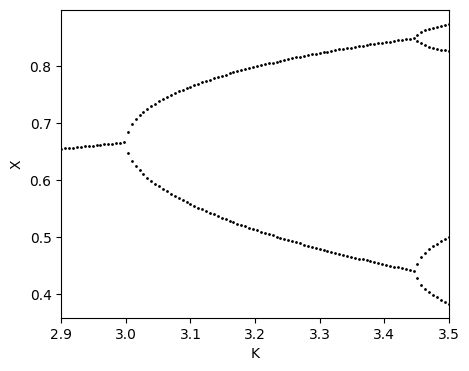

In [19]:
plot(2.9, 3.5)

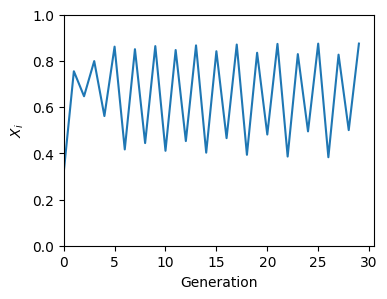

Set of stable points:  {0.50088, 0.875, 0.38282, 0.82694}


In [20]:
Logistic.plot(k=3.5)
p_set=Logistic.get_stable_points_set(k=3.5)
print("Set of stable points: ", p_set)

Plot of the histogram (2000 generations):

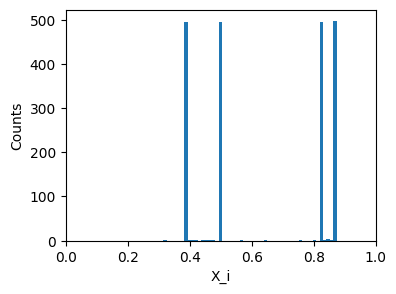

In [21]:
Logistic.plot(k=3.5, niter=2000, bins=50, hist=True) 

By increasing $k$ up to 4., a fractal behaviour arises:

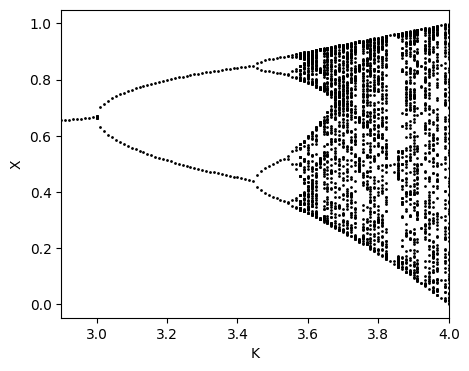

In [22]:
plot(2.9, 4.)

For k=3.55, the population oscillates among 8 different values:

Set of stable points:  {0.50603, 0.88737, 0.81266, 0.3548, 0.54047, 0.88168, 0.37033, 0.82781}

Histogram:


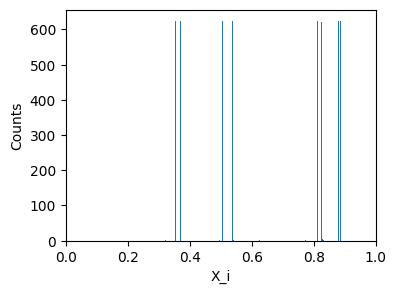

In [23]:
p_set=Logistic.get_stable_points_set(k=3.55)
print("Set of stable points: ", p_set)
print("\nHistogram:")
Logistic.plot(k=3.55, niter=5000, bins=200, hist=True)

In the case of k=3.60, the distribution shown by the histogram appears to be quite different from the cases considered above: 

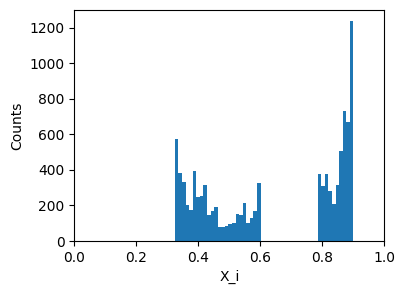

In [24]:
Logistic.plot(k=3.60, niter=10000, bins=50, hist=True)

Here is the plot of the sequence $x_n$ for the first 50 generations.   

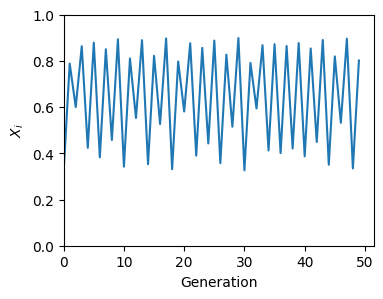

In [25]:
Logistic.plot(3.6, niter=50)

Again, in the analytic model, a unique stable value for the popolation is obtained even in the case of  $k=3.60$

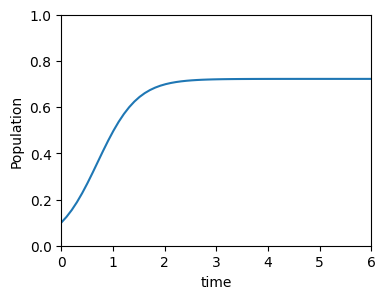

Limit value for x: 0.7222


In [26]:
x_tp=logistic(x_ini, 3.6)
plot_analytic()
x_limit=x_tp.limit(t, sym.oo).evalf()
print("Limit value for x: %6.4f" % x_limit)